In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import json
import os
import re
from collections import defaultdict


def extract_from_summary(file_path):
    with open(file_path, "r") as f:
        content = f.read()

    # Extract best model info
    best_model_match = re.search(
        r"OVERALL BEST MODEL:\s*Model: (\w+)\s*Validation Accuracy: ([\d\.]+)", content
    )

    # Extract test performance
    test_acc_match = re.search(r"TEST PERFORMANCE:\s*Test Accuracy: ([\d\.]+)", content)

    if best_model_match and test_acc_match:
        model_name = best_model_match.group(1)
        val_acc = float(best_model_match.group(2))
        test_acc = float(test_acc_match.group(1))

        return {"model": model_name, "val_acc": val_acc, "test_acc": test_acc}
    return None


def simplify_experiment_name(name):
    # Mapping experiment names to simpler descriptions
    if "f3_f4_c3_cz_c4_p3_p4_oz" in name:
        if "brow_furrow" in name or "face" in name:
            return "EEG+Face+Physio"
        else:
            return "EEG"
    elif "brow_furrow" in name or any(
        face_feature in name
        for face_feature in [
            "cheek_raise",
            "mouth_open",
            "nose_wrinkle",
            "upper_lip_raise",
        ]
    ):
        if "eda_raw" in name or "heart_rate" in name or "pupil" in name:
            return "Face+Physio"
        else:
            return "Face"
    else:
        return name


def extract_all_results(base_dir="results"):
    results = []

    # Walk through all directories in the results folder
    for root, dirs, files in os.walk(base_dir):
        # Look for summary.txt files
        if "summary.txt" in files:
            summary_path = os.path.join(root, "summary.txt")
            experiment_name = os.path.relpath(root, base_dir)

            result = extract_from_summary(summary_path)
            if result:
                result["full_experiment"] = experiment_name
                result["experiment"] = simplify_experiment_name(experiment_name)
                results.append(result)

    return results


def save_results(results, output_file="extracted_results.json"):
    # with open(output_file, 'w') as f:
    #     json.dump(results, f, indent=2)

    # Also print a summary table
    print("\nResults Summary:")
    print("=" * 60)
    print(f"{'Experiment':<50} {'Model':<30} {'Val Acc':<10} {'Test Acc':<10}")
    print("-" * 60)

    for r in results:
        print(
            f"{r['experiment']:<50} {r['model']:<30} {r['val_acc']:<10.4f} {r['test_acc']:<10.4f}"
        )


if __name__ == "__main__":
    results = extract_all_results()
    save_results(results)

    print(f"\nExtracted results from {len(results)} experiments.")
    print("Results saved to 'extracted_results.json'")


Results Summary:
Experiment                                         Model                          Val Acc    Test Acc  
------------------------------------------------------------
EEG                                                iTransformer                   0.5911     0.5368    
Face                                               PatchTST                       0.5751     0.5692    
experiment_pupil                                   iTransformer                   0.6805     0.6667    
experiment_eda_raw_heart_rate                      PatchTST                       0.7556     0.7556    
experiment_eda_raw                                 PatchTST                       0.7476     0.7624    
experiment_eda_raw_pupil                           PatchTST                       0.7412     0.7795    
EEG                                                EEGPhysioEnsemble              0.7460     0.7316    
experiment_eda_raw_heart_rate_pupil                PatchTST                       0.7508 

In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
    plot_single_prediction_confidence_heatmap,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


In [13]:
from src.data.database_manager import DatabaseManager

db = DatabaseManager()
with db:
    df = db.get_table("Trials")
df

trial_id,trial_number,participant_id,stimulus_seed,skin_patch,timestamp_start,timestamp_end,duration
u16,u8,u8,u16,u8,f64,f64,f64
1,1,1,870,1,200176.946,380187.1239,180010.1779
2,2,1,681,2,412801.8887,592813.1696,180011.2809
3,3,1,265,3,626262.7175,806289.7444,180027.0269
4,4,1,396,4,834066.1436,1.0141e6,180012.663
5,5,1,743,5,1.0434e6,1.2234e6,180028.4845
6,6,1,658,6,1.2588e6,1.4388e6,180027.9697
…,…,…,…,…,…,…,…
531,7,45,806,6,1.5396e6,1.7196e6,180026.746
532,8,45,952,5,1.7486e6,1.9287e6,180026.3914


In [14]:
config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
stimulus_seeds = config["stimulus"]["seeds"]
print(f"Using seeds for stimulus generation: {stimulus_seeds}")

Using seeds for stimulus generation: [133, 243, 265, 396, 467, 658, 681, 743, 806, 841, 870, 952]


In [28]:
feature_lists = [
    ["eda_raw"],
    ["heart_rate"],
    ["pupil"],
    ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate"],
    ["eda_raw", "heart_rate", "pupil"],
    ["face"],
    ["face", "eda_raw", "heart_rate", "pupil"],
    ["eeg"],
    ["eeg", "eda_raw"],
    ["eeg", "face", "eda_raw", "heart_rate", "pupil"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[7]
feature_list_str = "_".join(feature_list)

In [29]:
results = {}

# Load data from database
df = load_data_from_database(feature_list=feature_list)

# Load model
json_path = Path(f"results/experiment_{feature_list_str}/results.json")
dictionary = json.loads(json_path.read_text())
model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(model_path, device="cpu")
)


20:47:07 | INFO    | utils | Using device: cpu
20:47:07 | INFO    | utils | Loaded FacePhysioEnsemble model with test accuracy 0.78 to cpu
20:47:07 | INFO    | utils | Input shape: (70, 8) | Features: ['brow_furrow', 'cheek_raise', 'mouth_open', 'nose_wrinkle', 'upper_lip_raise', 'eda_raw', 'heart_rate', 'pupil'] | Sample duration: 7000 ms
20:47:07 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
20:47:07 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
20:47:07 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}


In [30]:
# Prepare data
_, _, _, _, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
)
test_groups = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
    only_return_test_groups=True,
)
test_ids = np.unique(test_groups)
# train data is not used in this analysis, but we need to create the dataloaders
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


20:47:10 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
20:47:11 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
20:47:11 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
20:47:11 | DEBUG   | data_preparation | Offsets for intervals: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
20:47:11 | DEBUG   | data_preparation | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
20:47:11 | INFO    | data_preparation | Number of unique participants in training set: 24
20:47:11 | INFO    | data_preparation | Number of unique participants in validation set: 9
20:47:11 | INFO    | data_preparation | Number of unique participants in test set: 9
20:47:11 | DEBUG   | data_preparation | Participant IDs in test set: [ 5  9 14 20 26 27 30 31 40]
20:47:11 | DEBUG   | sample_c

In [31]:
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,ppg_raw,heart_rate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,200180.9348,0.0,0.38375,19.449335,1435.748378,75.629597,4.755102,4.439214,4.449027,4.767109,4.608068,0.343433,0.000149,0.004032,0.00151,0.001383,0.0,870,1,0,0,1,1,1,0,0
1,1,1,200280.9348,0.000056,0.395091,19.590757,1374.318473,76.071842,4.767394,4.445163,4.449073,4.76687,4.607972,0.320498,0.000148,0.003763,0.001418,0.001302,100.0,870,1,0,0,1,1,1,0,0
1,1,1,200380.9348,0.000241,0.406316,19.701952,1388.482957,76.571757,4.800592,4.455469,4.452249,4.768114,4.610181,0.299536,0.000148,0.003514,0.001332,0.001228,200.0,870,1,0,0,1,1,1,0,0
1,1,1,200480.9348,0.000572,0.415328,19.843161,1382.204807,76.593026,4.834793,4.471024,4.459188,4.770803,4.614996,0.283138,0.000151,0.003353,0.001271,0.001174,300.0,870,1,0,0,1,1,1,0,0
1,1,1,200580.9348,0.001049,0.424044,19.981172,1359.66813,76.493139,4.859153,4.48903,4.46891,4.772641,4.620776,0.273597,0.000153,0.003259,0.001239,0.001149,400.0,870,1,0,0,1,1,1,0,0
1,1,1,200680.9348,0.001676,0.435615,20.092337,1389.969089,76.637526,4.867257,4.50087,4.47383,4.773587,4.623708,0.2573,0.000152,0.003095,0.001181,0.001107,500.0,870,1,0,0,1,1,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
496,4,42,1.1405e6,0.031406,0.0,15.128855,1340.298906,62.466868,3.72269,3.516138,3.52679,3.721894,3.624342,0.009496,0.000166,0.077258,0.001999,0.003419,179500.0,806,3,2395,1437,0,0,0,0,0
496,4,42,1.1406e6,0.030945,0.0,15.12266,1373.159491,62.743545,3.681108,3.505007,3.52249,3.736287,3.629388,0.009385,0.000165,0.086661,0.001937,0.003302,179600.0,806,3,2395,1437,0,0,0,0,0


In [32]:
feature_list

['brow_furrow',
 'cheek_raise',
 'mouth_open',
 'nose_wrinkle',
 'upper_lip_raise',
 'eda_raw',
 'heart_rate',
 'pupil']

In [33]:
# Analyze the entire test dataset
all_probabilities = {}
all_participant_trials = {}

for stimulus_seed in stimulus_seeds:
    probabilities, participant_trials = analyze_test_dataset_for_one_stimulus(
        df, model, feature_list, test_ids, stimulus_seed, sample_duration_ms
    )

    all_probabilities[stimulus_seed] = probabilities
    all_participant_trials[stimulus_seed] = participant_trials


20:47:13 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
20:47:14 | INFO    | model_inference | Processing participant 5...
20:47:14 | INFO    | model_inference | Created 174 samples of 7000ms duration with 1000ms spacing
20:47:14 | INFO    | model_inference | Processing participant 9...
20:47:14 | INFO    | model_inference | Created 174 samples of 7000ms duration with 1000ms spacing
20:47:14 | INFO    | model_inference | Processing participant 14...
20:47:15 | INFO    | model_inference | Created 174 samples of 7000ms duration with 1000ms spacing
20:47:15 | INFO    | model_inference | Processing participant 20...
20:47:15 | INFO    | model_inference | Created 174 samples of 7000ms duration with 1000ms spacing
20:47:15 | INFO    | model_inference | Processing participant 26...
20:47:15 | INFO    | model_inference | Created 174 samples of 7000ms duration with 1000ms spacing
20:47:15 | INFO    | model_inference | Processing participant 27...
20:47:15 | INFO

In [53]:
np.array(all_probabilities[133]["5"][0]).max()

np.float64(0.7310585975646973)

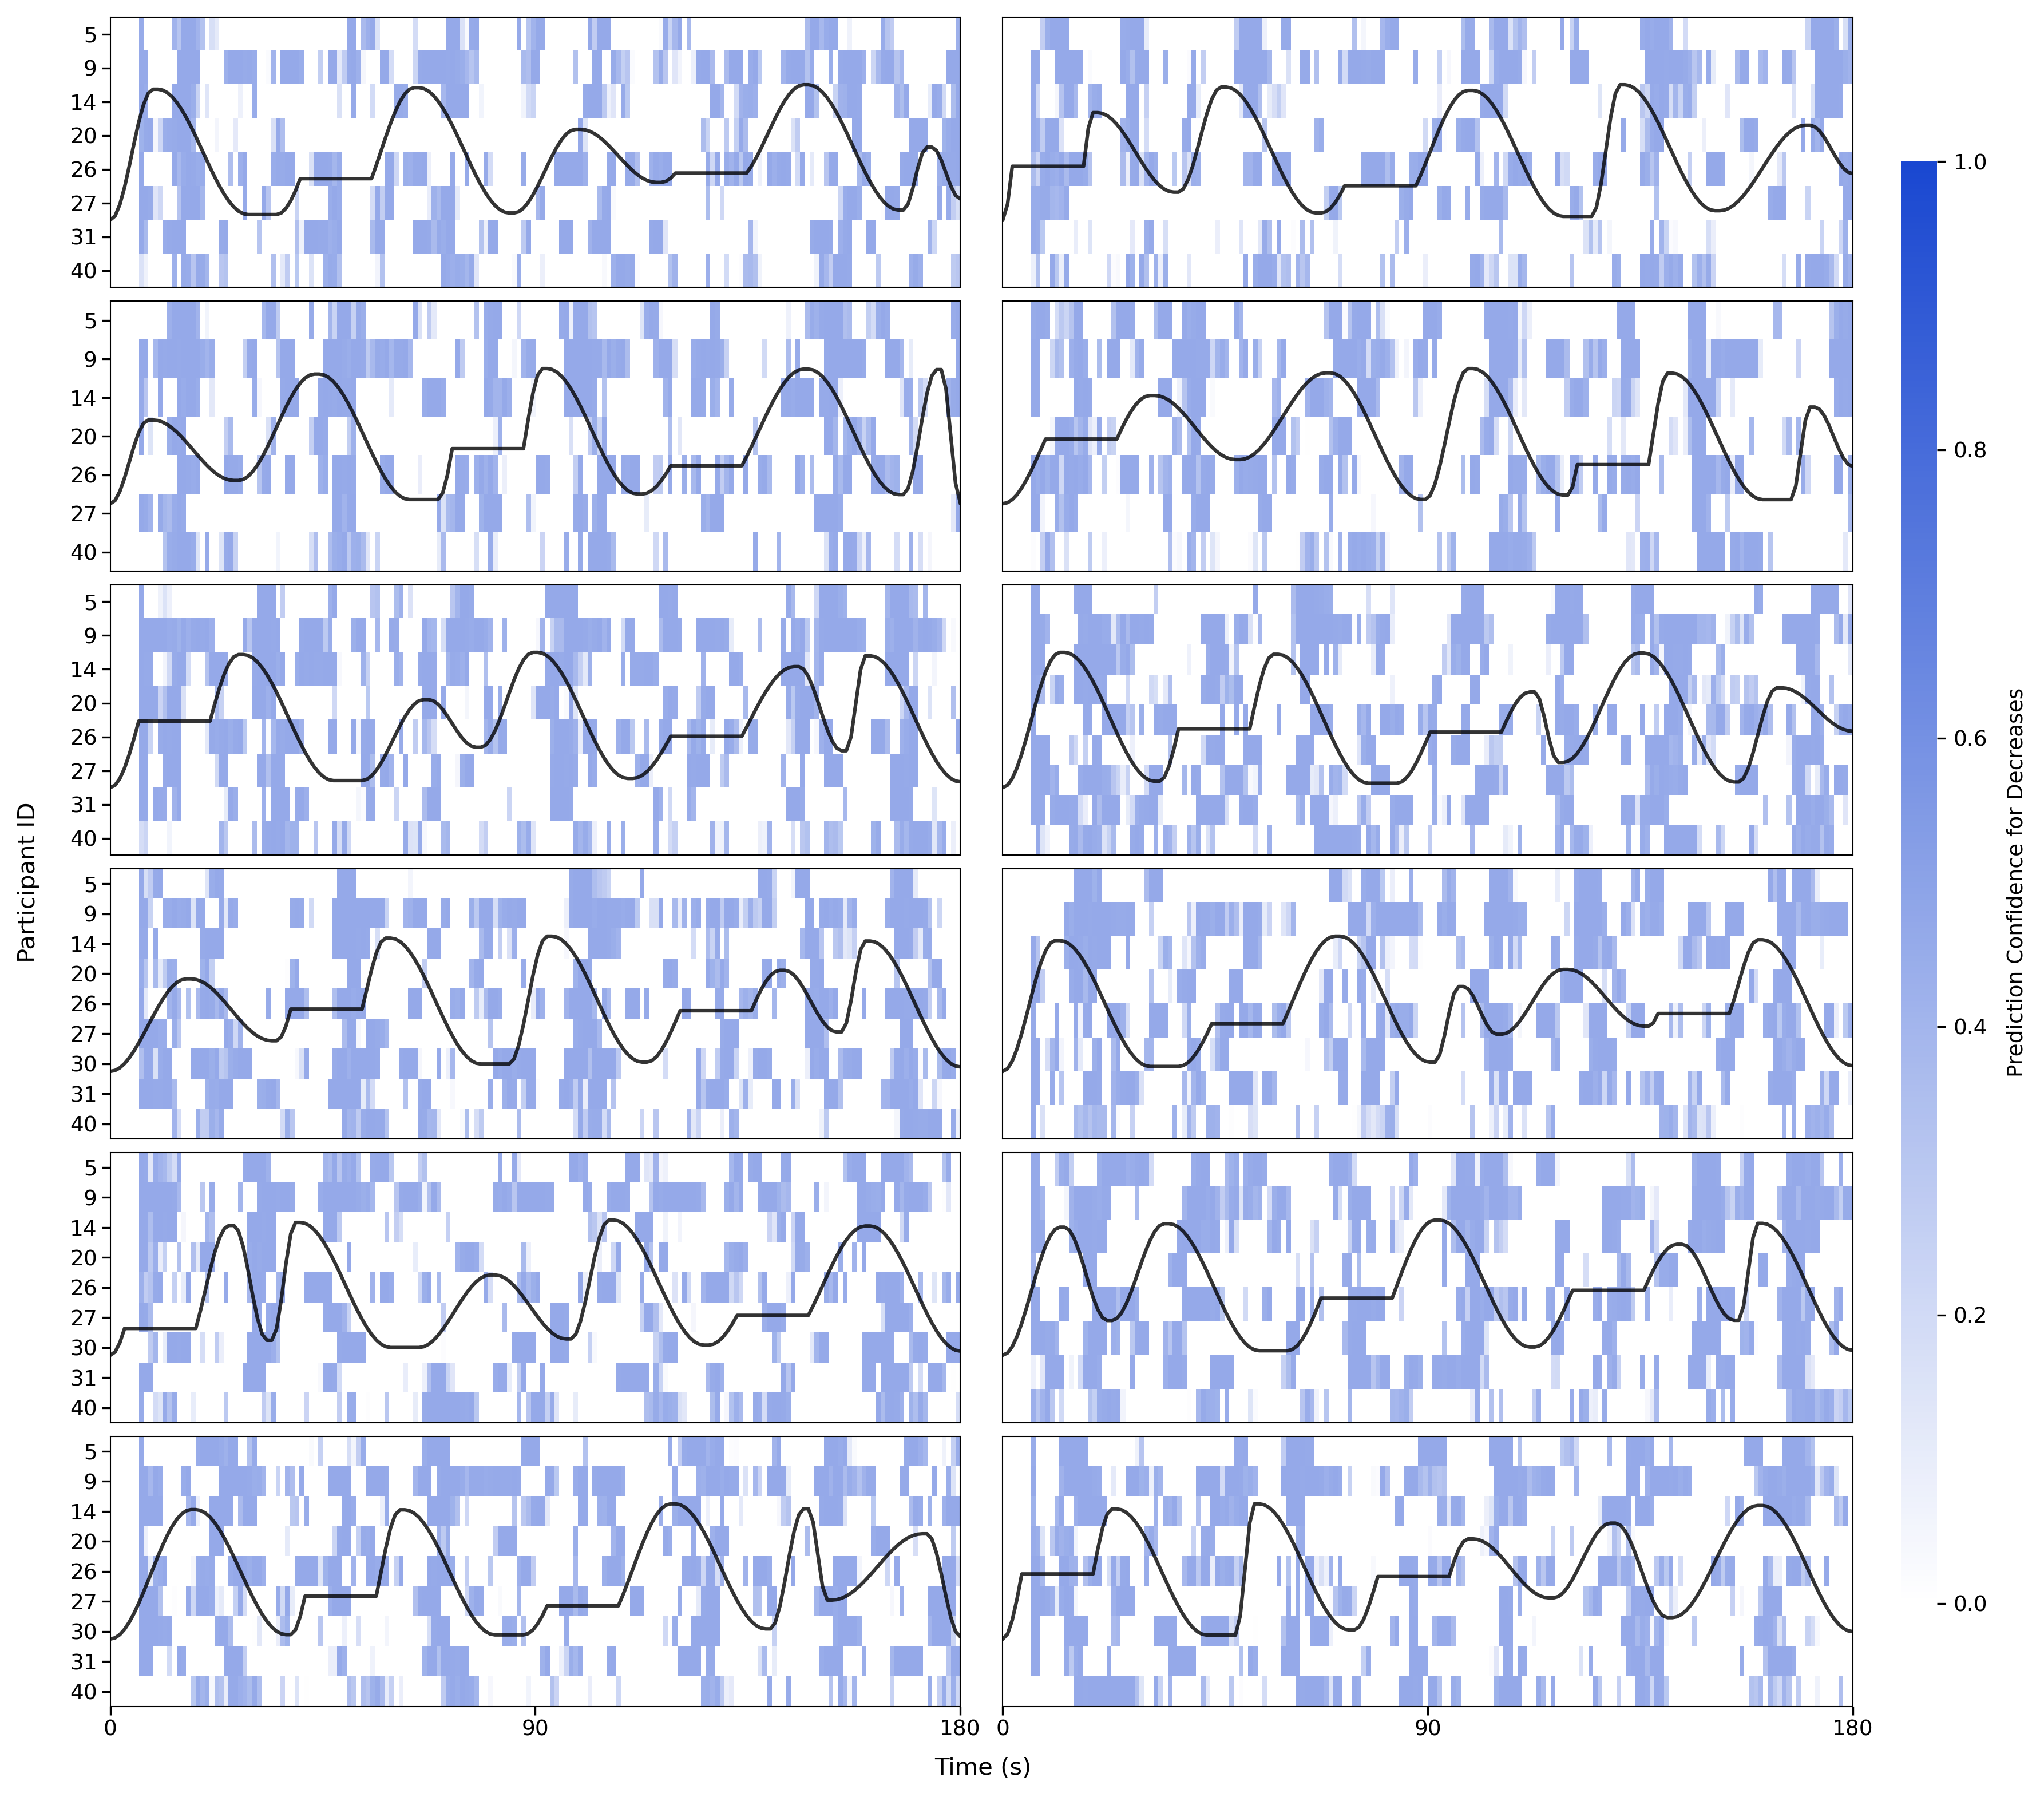

In [43]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.5,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)

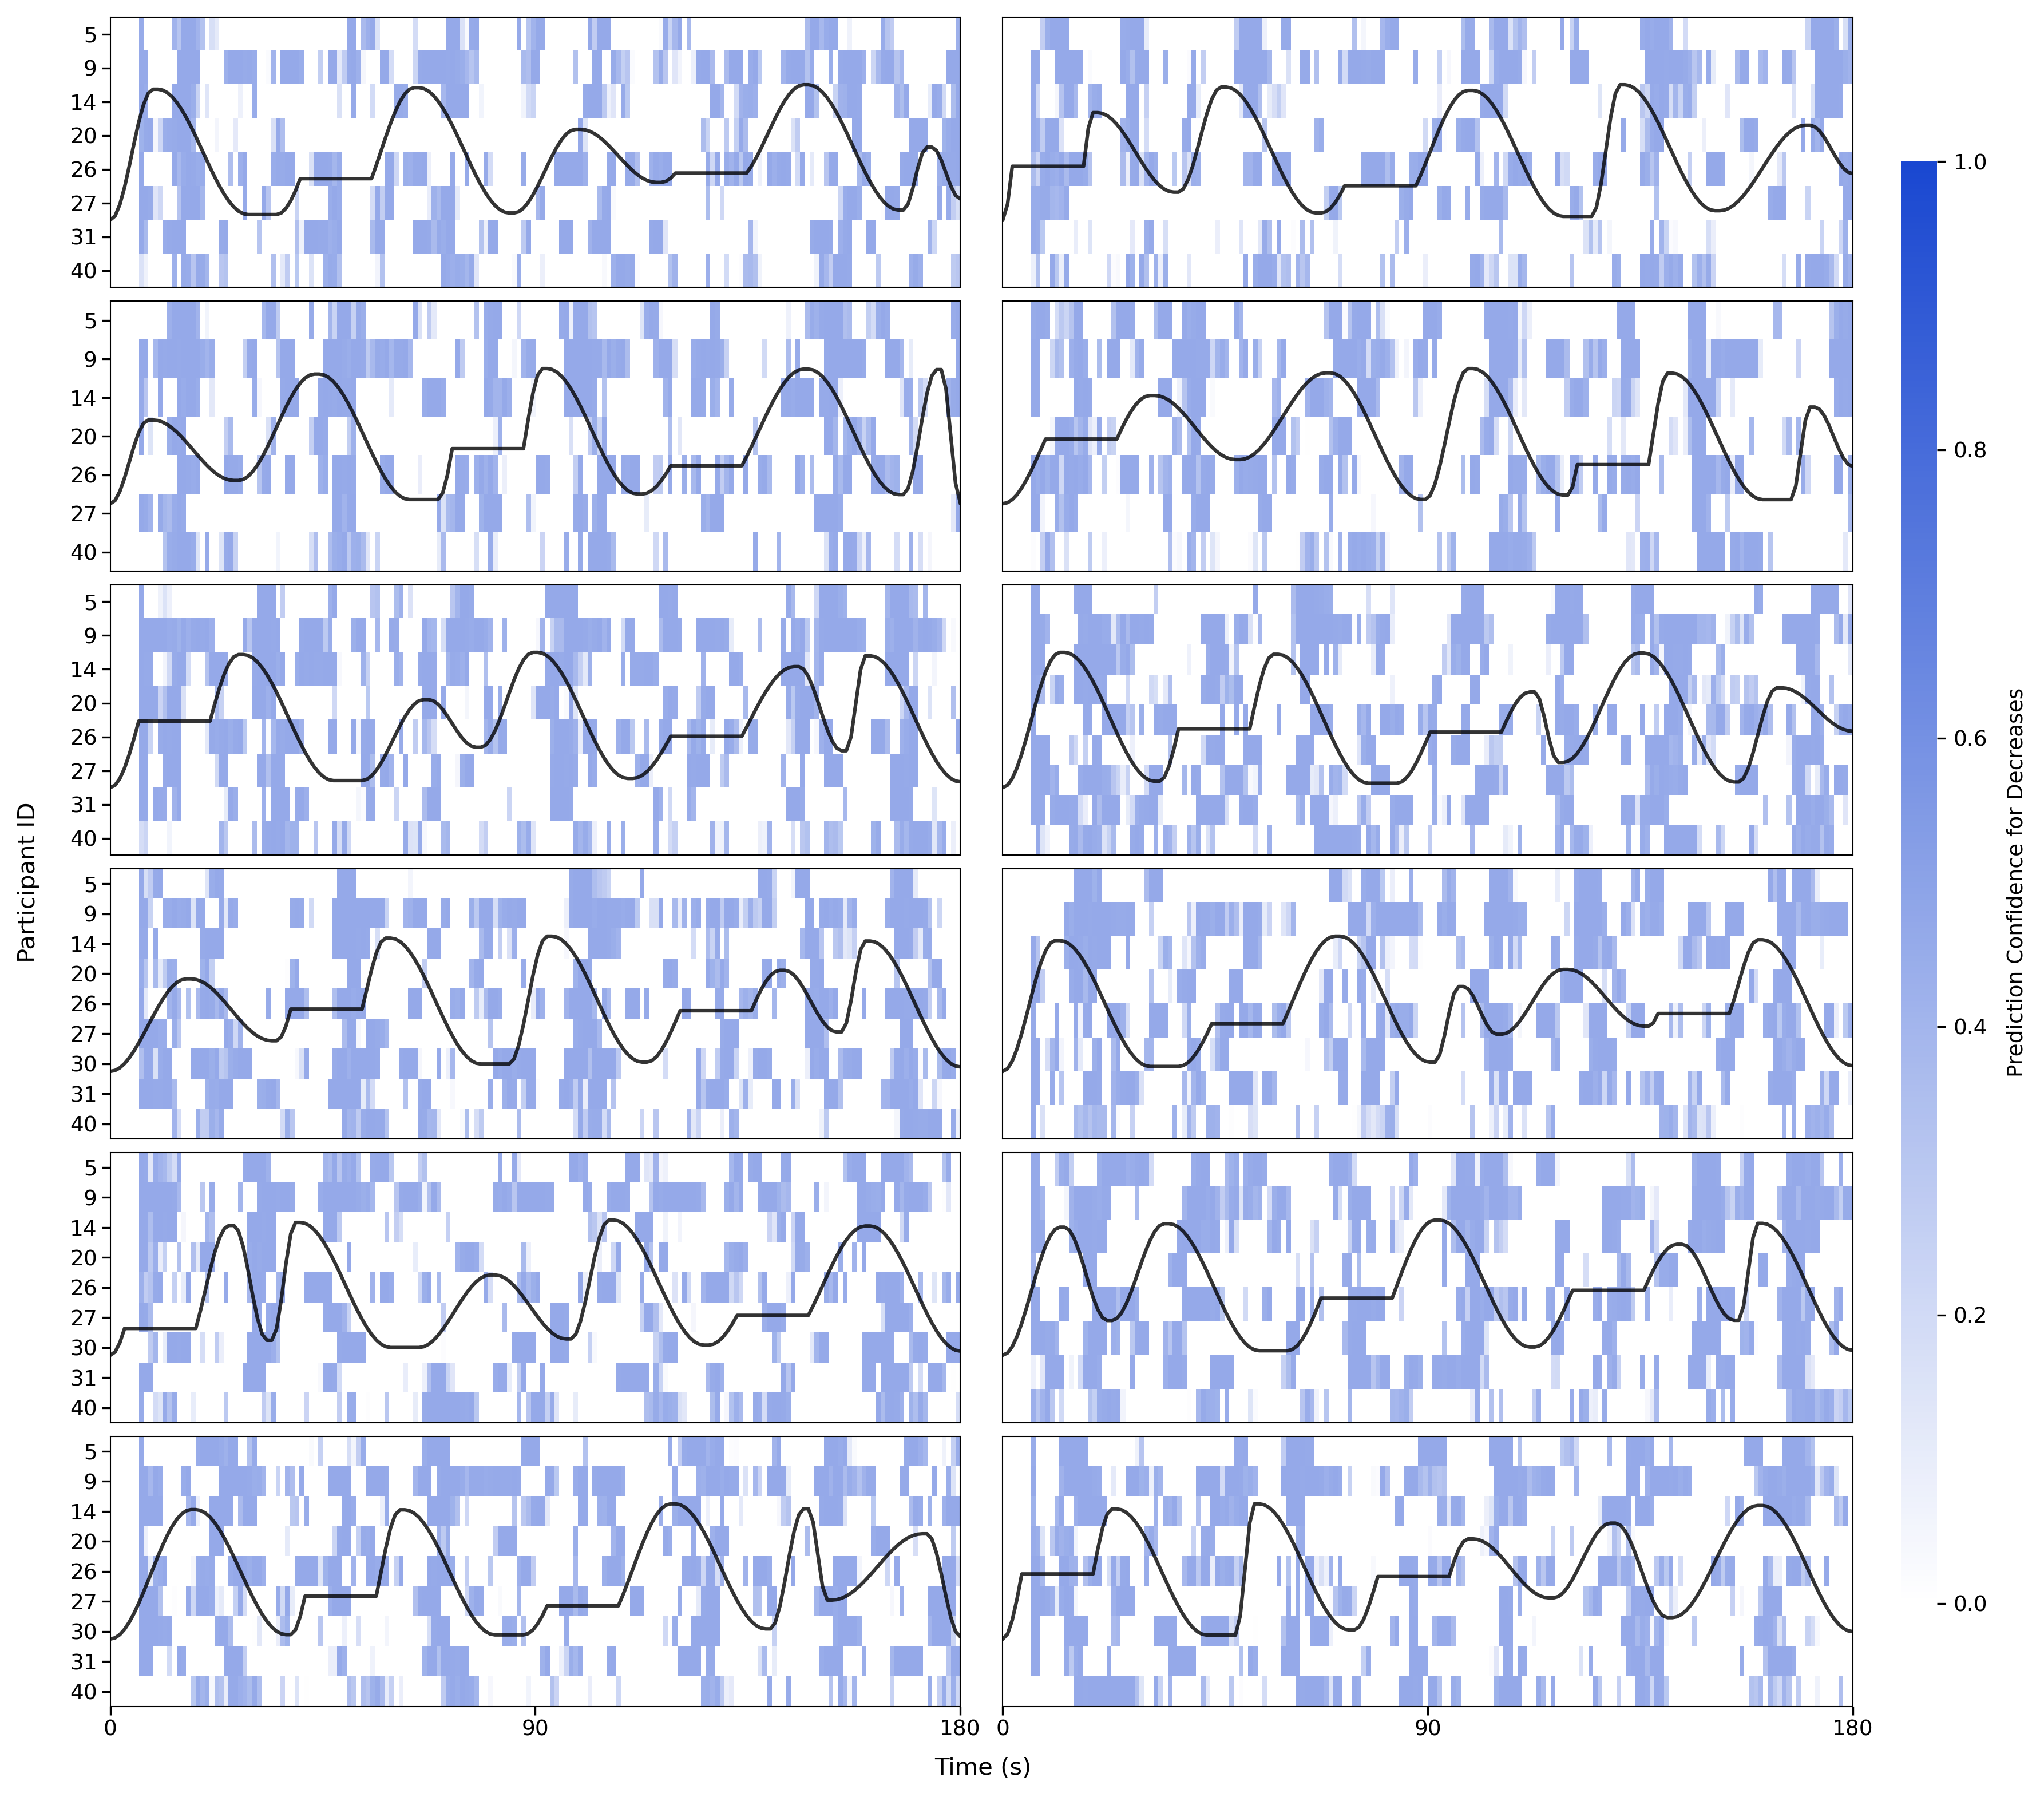

In [42]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.50,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)

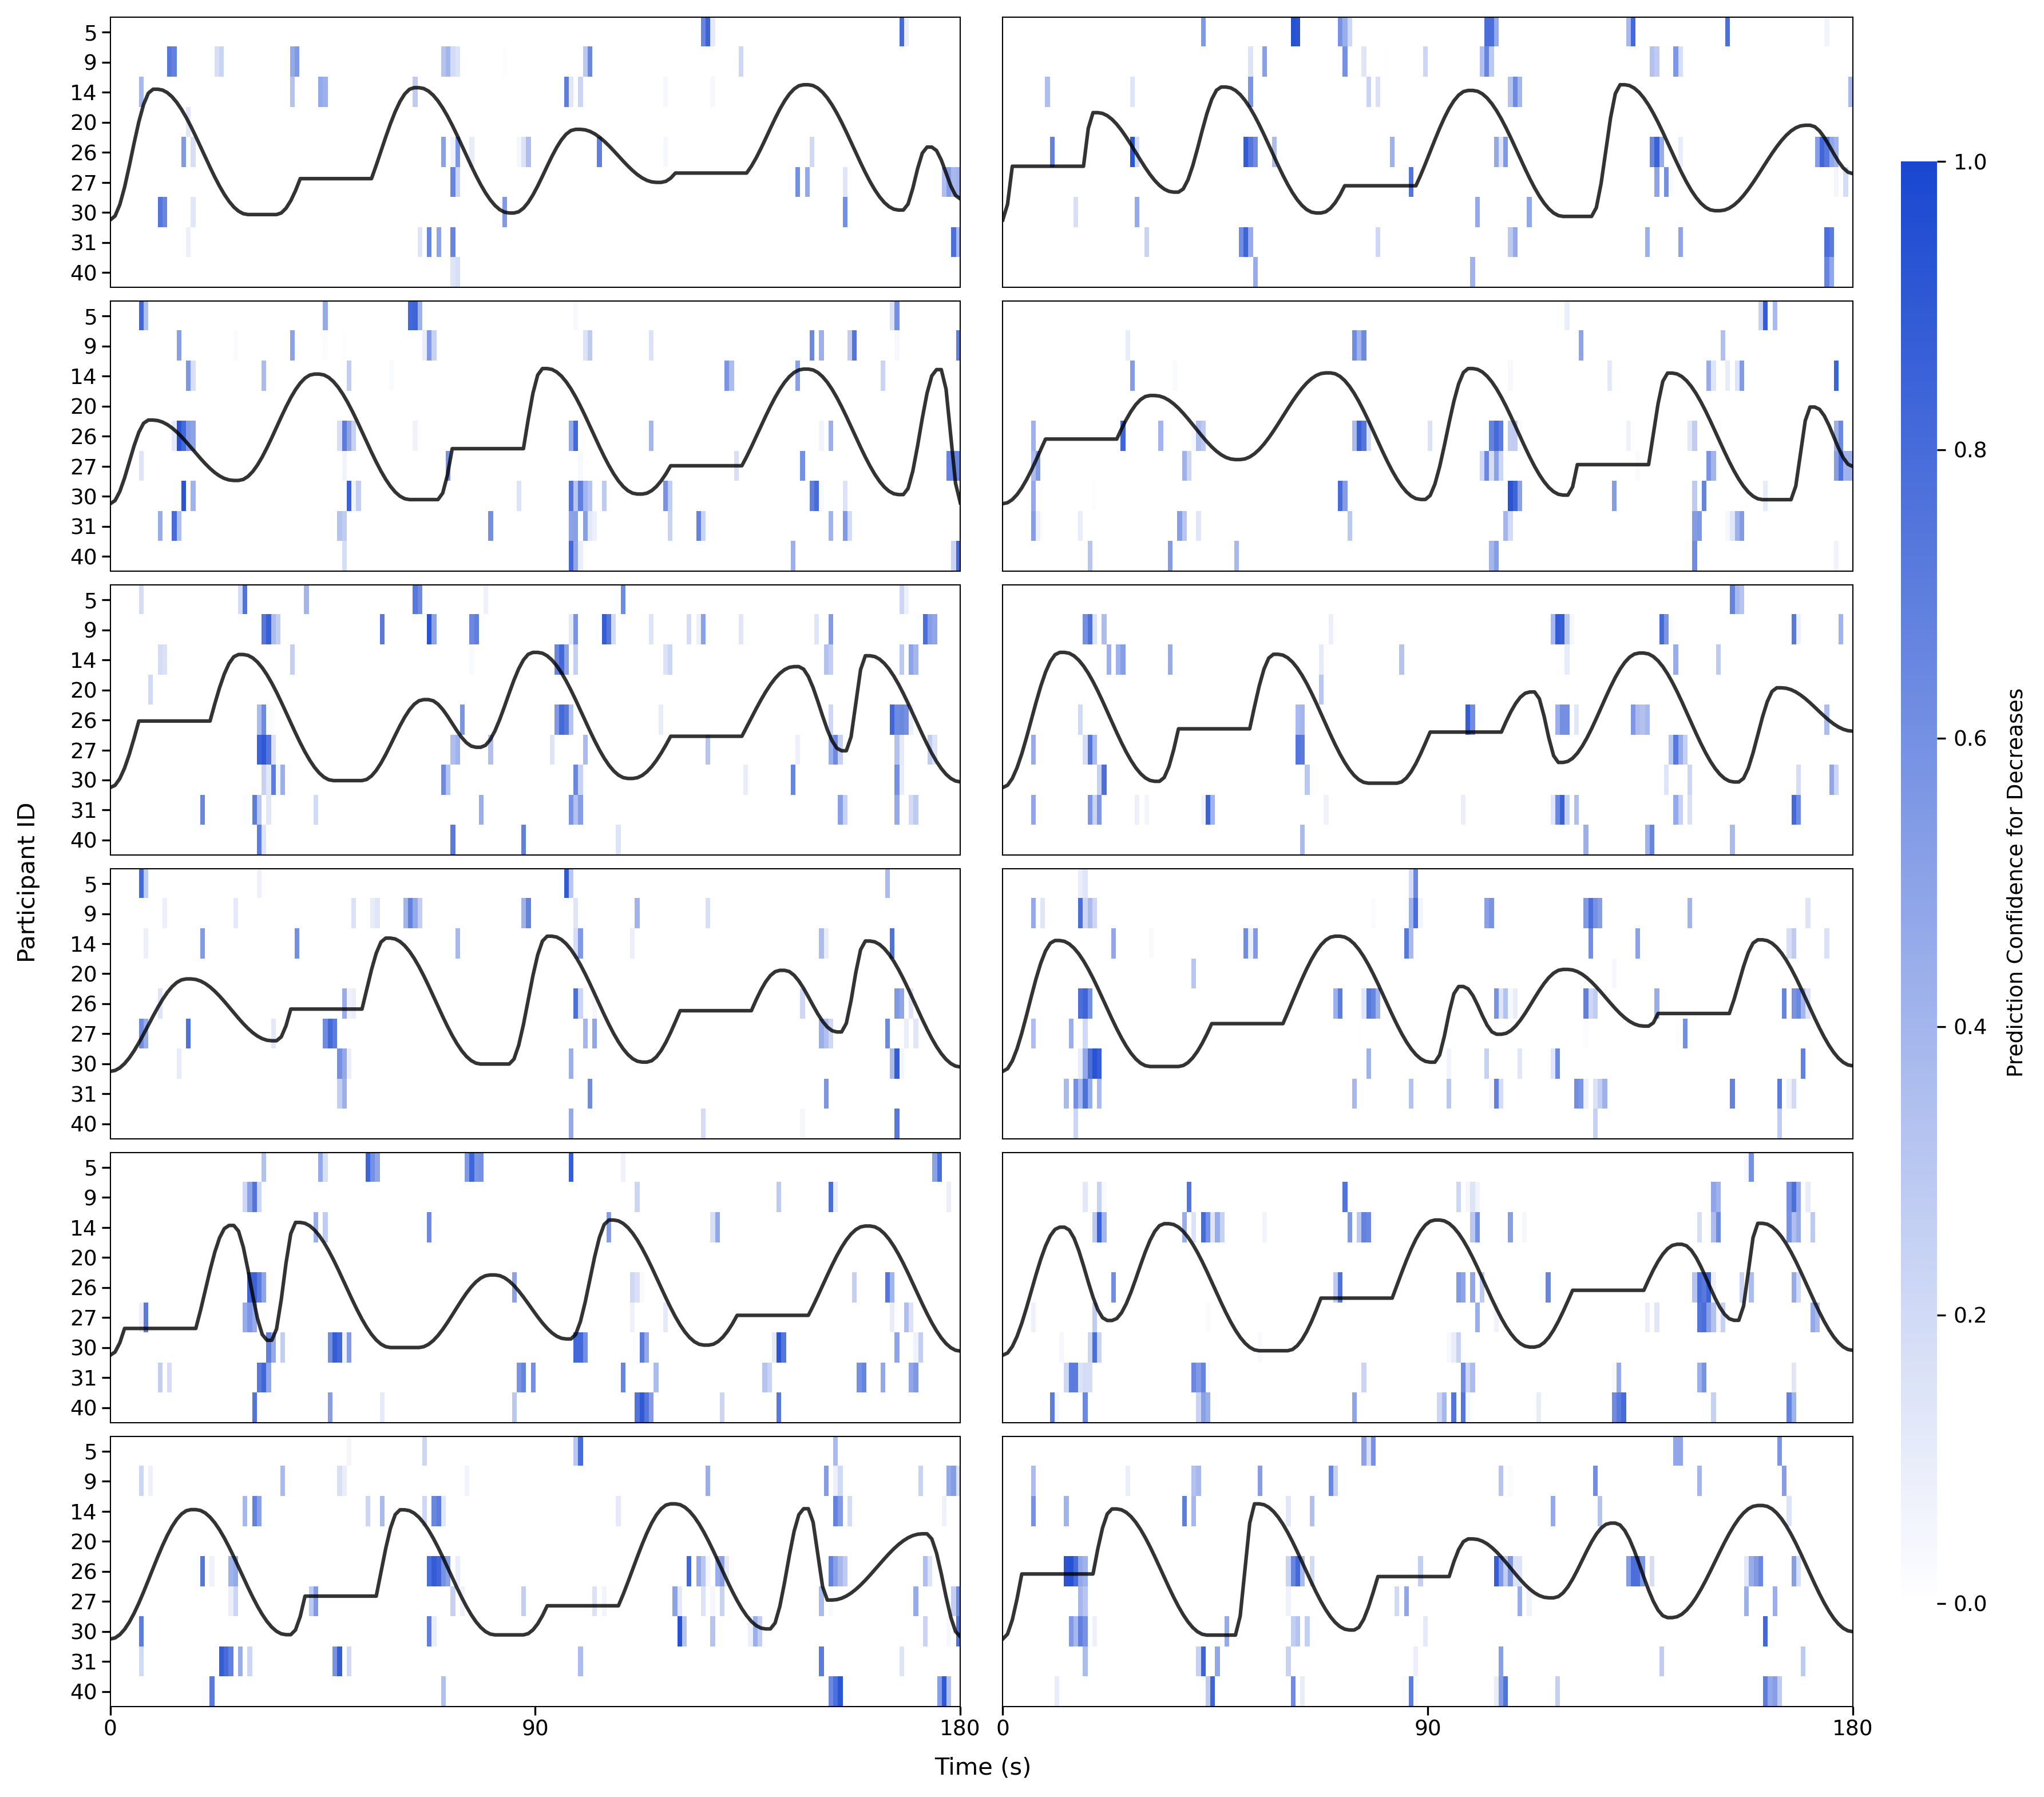

In [ ]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.95,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)

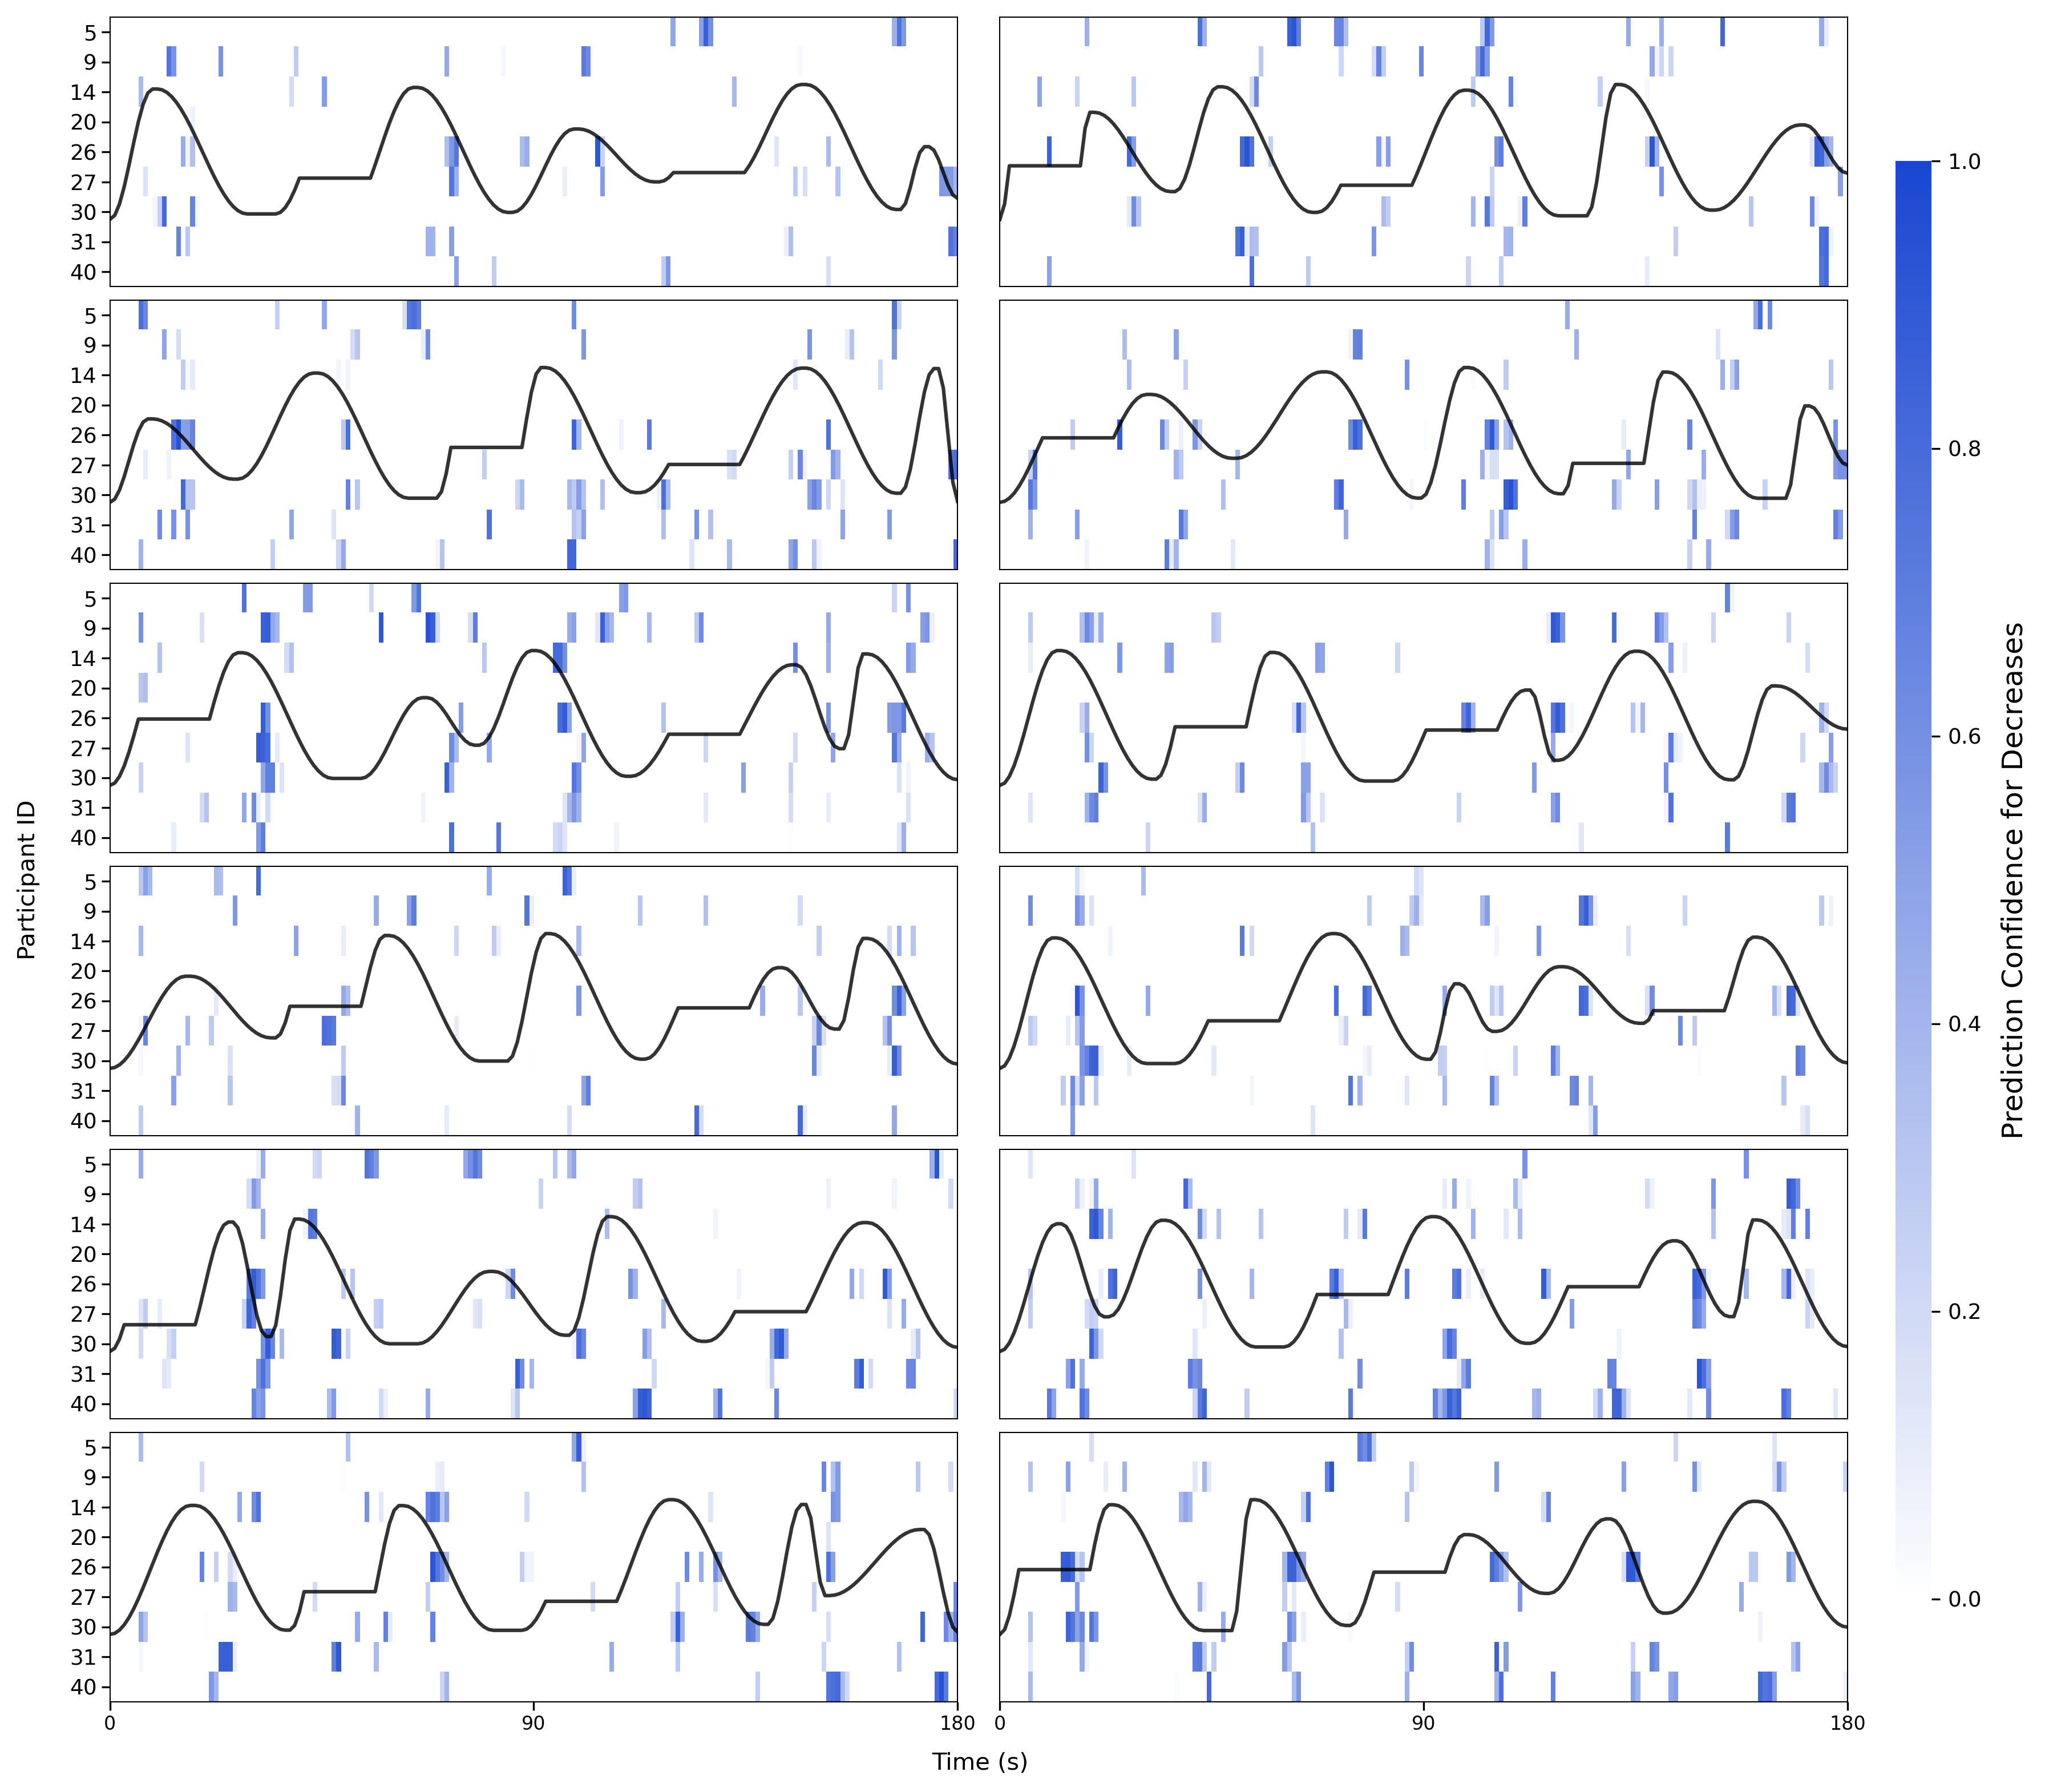

In [ ]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.95,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)


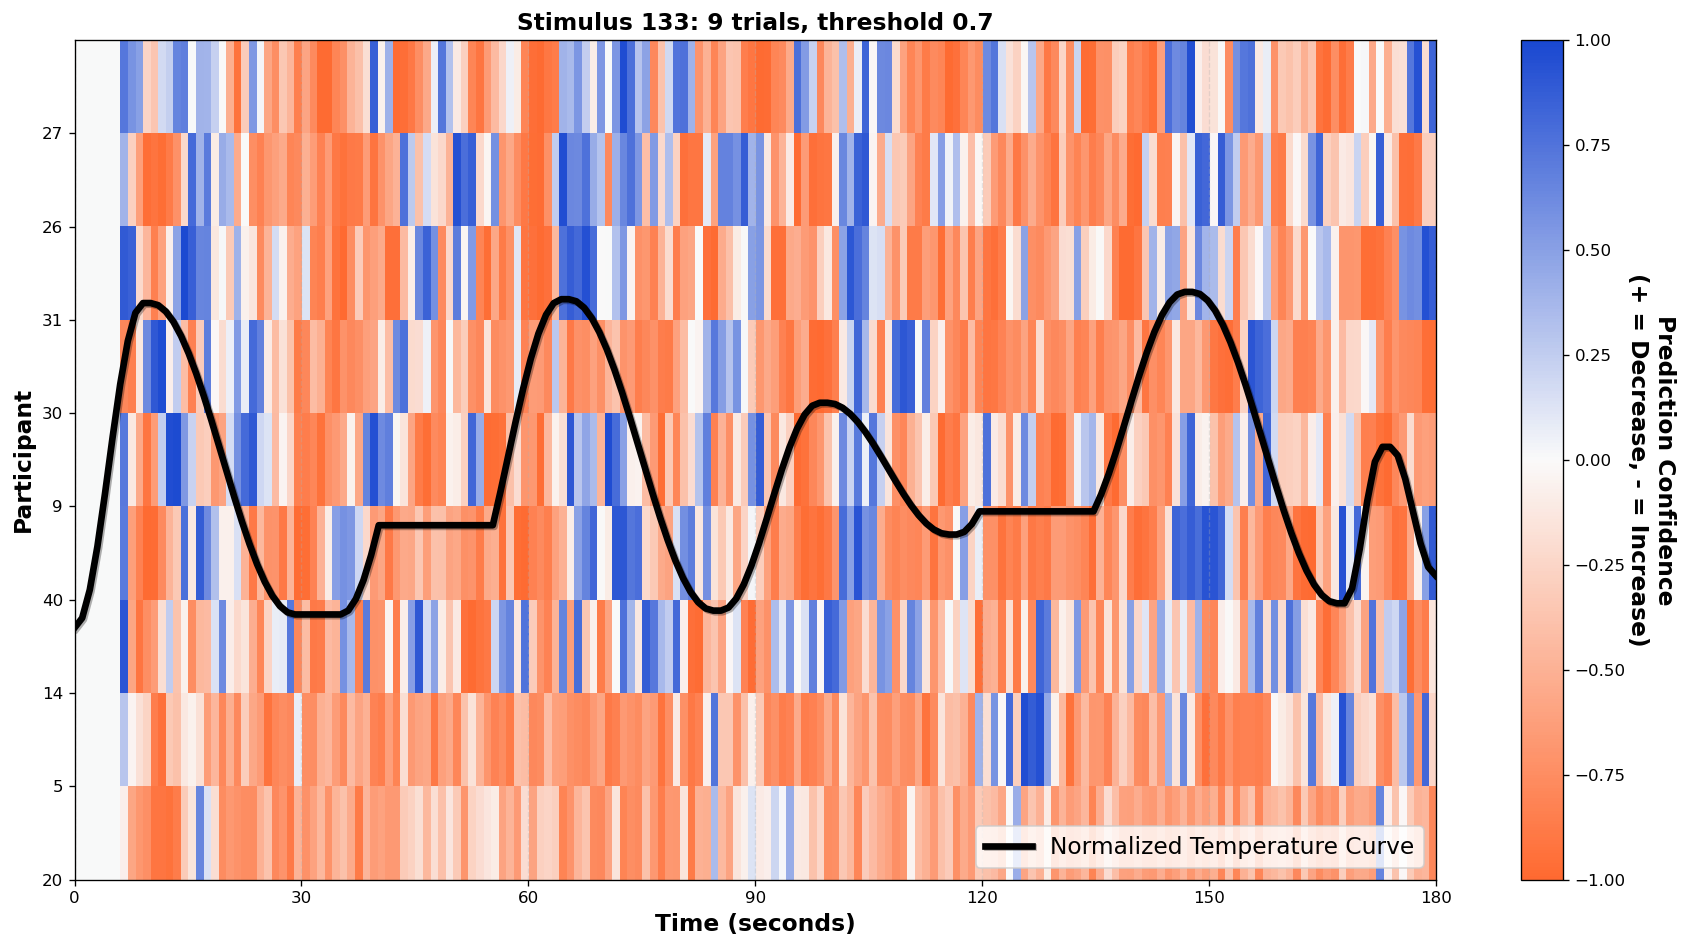

In [ ]:
stimulus_seed = stimulus_seeds[0]
threshold = 0.7

a = plot_single_prediction_confidence_heatmap(
    probabilities=all_probabilities[stimulus_seed],
    stimulus_seed=stimulus_seed,
    classification_threshold=threshold,
    sample_duration=sample_duration_ms,
)